# Optimizing the parameters of the Lorenz system
This notebook explores uses PyTorch's autograd to optimize Lorenz's non-linear dynamical problem. A three-dimensional state vector evolves non-linear in this coupled system and the solution depends on three parameters. The notebook covers and compares several different approaches to tune the parameters: Optimizing the parameters using down-gradient optimization based on a single scenario, "online" optimization of the parameters

## Lorenz equations and numerical discretization


In [105]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def lorenz_torch(state, sigma, rho, beta):
    """
    state: tensor of shape (3,) or (..., 3)
    sigma, rho, beta: torch tensors (can require gradients)
    """
    x, y, z = state[..., 0], state[..., 1], state[..., 2]

    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z

    return torch.stack([dx, dy, dz], dim=-1)

def euler_step_torch(state, dt, sigma, rho, beta):
    return state + dt * lorenz_torch(state, sigma, rho, beta)

Let's write a function that can advance an initial state for a certain number of time steps.

In [106]:
def run_lorenz(state0, t0, steps, dt, sigma, rho, beta):
    state = state0
    trajectory = []
    time = []

    for i in range(steps):
        state = euler_step_torch(state, dt, sigma, rho, beta)
        trajectory.append(state)
        time.append(torch.tensor(t0 + (i + 1) * dt))

    return torch.stack(time), torch.stack(trajectory)

## Down-gradient optimization of a past scenario
Let's now run a down-gradient optimization for one scenario. That is, let's define the "true" trajectory for one initial state and let's iterate over many parameter configurations (i.e., trials) to minimize the distance to the true trajectory (i.e., loss). 

Let's now run a down-gradient optimization for one scenario. That is, let's define the "true" trajectory for one initial state and let's iterate over many parameter configurations (i.e., trials) to minimize the distance to the true trajectory (i.e., loss). 

The approach is to define the parameters first with initial guesses and to set `requires_grad=True` such that the computational graph will get computed to enable subsequent down-gradient incremental changes to the parameter set.requires_grad=True such that the computational graph will get computed to enable later down-gradient incremental changes to the parameter set. 

The function below takes in the number of total time steps to use to solve the optimization. Each trajectory is currently covered by 100 time steps, such that a total of 10000 time steps would equate to 100 trials.

In [ ]:
def scenario_optimization(state0, num_tot_steps=10000):
    # Set number of trials 
    num_trials = int(num_tot_steps / 100)


    # Initial parameter choices
    sigma = torch.tensor(8.0, requires_grad=True)
    rho   = torch.tensor(20.0, requires_grad=True)
    beta  = torch.tensor(3.0, requires_grad=True)

    true_time, true_traj = get_observations(state0)

    optimizer = torch.optim.Adam([sigma, rho, beta], lr=1e-2)

    # Store trajectories and losses for visualization
    stored_trajectories = []
    stored_losses = []

    for trial in range(num_trials):
        optimizer.zero_grad()

        pred_time, pred_traj = run_lorenz(state0, t0=0, steps=100, dt=0.01, sigma=sigma, rho=rho, beta=beta)
        loss = torch.mean((pred_traj - true_traj) ** 2)

        loss.backward()   # <-- AUTOGRAD HERE
        optimizer.step()

        if trial % 20 == 0 or trial == num_trials - 1:
            print(f"Trial {trial:4d} | Loss={loss.item():.6f} "
                f"sigma={sigma.item():.3f}, rho={rho.item():.3f}, beta={beta.item():.3f}")
            # Store trajectory and loss for plotting
            stored_trajectories.append((trial, pred_traj.detach().clone()))
            stored_losses.append((trial, loss.item()))
    return [traj for _, traj in stored_trajectories], [loss for _, loss in stored_losses]



Trial    0 | Loss=118.959099 sigma=8.010, rho=20.010, beta=2.990
Trial   20 | Loss=107.728981 sigma=8.210, rho=20.210, beta=2.790
Trial   40 | Loss=96.659782 sigma=8.409, rho=20.411, beta=2.592
Trial   60 | Loss=86.020088 sigma=8.605, rho=20.613, beta=2.398
Trial   80 | Loss=76.130486 sigma=8.797, rho=20.813, beta=2.213
Trial  100 | Loss=67.271805 sigma=8.983, rho=21.011, beta=2.042
Trial  120 | Loss=59.609520 sigma=9.163, rho=21.205, beta=1.892
Trial  140 | Loss=53.157078 sigma=9.335, rho=21.393, beta=1.765
Trial  160 | Loss=47.790936 sigma=9.499, rho=21.575, beta=1.665
Trial  180 | Loss=43.305321 sigma=9.655, rho=21.749, beta=1.593
Trial  200 | Loss=39.480358 sigma=9.804, rho=21.917, beta=1.548
Trial  220 | Loss=36.131512 sigma=9.946, rho=22.078, beta=1.527
Trial  240 | Loss=33.129192 sigma=10.082, rho=22.234, beta=1.525
Trial  249 | Loss=31.868734 sigma=10.141, rho=22.303, beta=1.529


Now let's run this from an initial state.

In [ ]:
state0 = torch.tensor([1.0, 1.0, 1.0])
trajectories, losses = scenario_optimization(state0, num_tot_steps=200000)

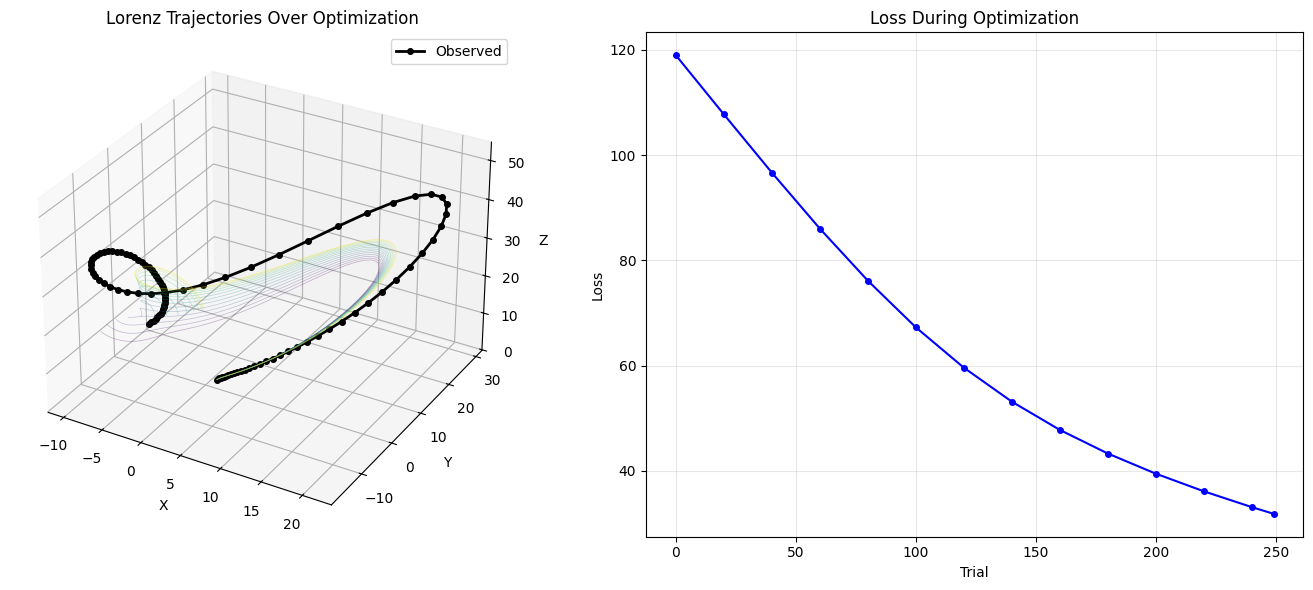


Total trajectories plotted: 14 (plus the observed one)
Final loss: 31.868734


In [118]:
# Visualize the trajectories
fig = plt.figure(figsize=(14, 6))

# 3D plot of all trajectories
ax1 = fig.add_subplot(121, projection='3d')

# Plot the true (observed) trajectory
true_traj_np = true_traj.detach().numpy()
ax1.plot(true_traj_np[:, 0], true_traj_np[:, 1], true_traj_np[:, 2], 
         'o-', linewidth=2, markersize=4, label='Observed', color='black')

# Plot stored trajectories with color gradient representing iterations
colors = plt.cm.viridis(np.linspace(0, 1, len(stored_trajectories)))
for i, trial_traj in enumerate(stored_trajectories):
    trial, traj = trial_traj
    traj_np = traj.numpy()
    ax1.plot(traj_np[:, 0], traj_np[:, 1], traj_np[:, 2], 
             alpha=0.3, linewidth=0.5, color=colors[i])

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Lorenz Trajectories Over Optimization')
ax1.legend()

# Loss curve
ax2 = fig.add_subplot(122)
trials, losses = zip(*stored_losses)
ax2.plot(trials, losses, 'b-', marker='o', markersize=4)
ax2.set_xlabel('Trial')
ax2.set_ylabel('Loss')
ax2.set_title('Loss During Optimization')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal trajectories plotted: {len(stored_trajectories)} (plus the observed one)")
print(f"Final loss: {losses[-1]:.6f}")

## Online parameter estimation in real time
This works fine. But one problem is that we can carry out this type of optimization only if we have observations for the full trajectory, which for some systems might only be available for past dates. That is, the optimization can only occur for past scenarios. An alternative tested next is to assume that observations trickle in in real-time. In that case, we can adjust the parameters in real-time as we move forward to arrive at an optimal parameter configuration over time. In that sense, we use the parameters to nudge the system to the observations over time. 

In [119]:
# Reset parameters for online estimation
sigma_online = torch.tensor(8.0, requires_grad=True)
rho_online   = torch.tensor(20.0, requires_grad=True)
beta_online  = torch.tensor(3.0, requires_grad=True)

# Starting state
current_state = state0.clone()
current_time = 0.0

# Extract times and states from true trajectory
true_times = true_time
true_states = true_traj

# Store results for visualization
online_trajectories = []
online_losses = []
online_params = []

# Number of optimization trials per observation
# In the previous optimization we ran 2000 trials, each 100 time steps
# Let's keep the total number of simulated steps the same such that per 
# time step we optimize with n_trials_online trials
n_trials_online = int(25000 / 100)

# Process each observation
for obs_idx in range(len(true_states)):
    target_time = true_times[obs_idx].item()
    dt_to_target = target_time - current_time
    num_steps_to_target = 1 #int(dt_to_target / 0.01)  # Currently one step from previous observation to next
    observed_state = true_states[obs_idx]
    target_time = num_steps_to_target * 0.01 + current_time
    # Optimizer for this online step
    optimizer_online = torch.optim.Adam([sigma_online, rho_online, beta_online], lr=1e-2)
    
    best_loss = float('inf')
    best_pred_state = None
    
    # Run N optimization trials for this observation
    for trial in range(n_trials_online):
        optimizer_online.zero_grad()
        
        # Advance from current state to next observation point
        next_state = run_lorenz(current_state, current_time, num_steps_to_target, 0.01, sigma_online, rho_online, beta_online)[1][-1]
        
        # Compute loss against observed state
        loss = torch.mean((next_state - observed_state) ** 2)
        
        loss.backward()
        optimizer_online.step()
        
        # Track best solution
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_pred_state = next_state.detach().clone()
    
    # Update current state and time with optimal prediction
    current_state = best_pred_state.detach().requires_grad_(True)
    current_time = target_time
    
    # Store results
    online_trajectories.append((obs_idx, current_state.detach().clone()))
    online_losses.append((obs_idx, best_loss))
    online_params.append({
        'obs_idx': obs_idx,
        'sigma': sigma_online.item(),
        'rho': rho_online.item(),
        'beta': beta_online.item(),
        'loss': best_loss
    })
    
    if obs_idx % 1 == 0 or obs_idx == len(true_traj) - 1:
        print(f"Obs {obs_idx:3d} | Loss={best_loss:.6f} | "
              f"sigma={sigma_online.item():.3f}, rho={rho_online.item():.3f}, beta={beta_online.item():.3f}")

# Compute final loss from all concatenated online trajectories
final_online_traj = torch.stack([traj for _, traj in online_trajectories])
final_loss = torch.mean((final_online_traj - true_states) ** 2).item()
print(f"Final online estimation loss: {final_loss:.6f}")

print(f"\nOnline estimation complete. Processed {len(true_traj)-1} observations.")

Obs   0 | Loss=0.001077 | sigma=8.000, rho=22.325, beta=2.667
Obs   1 | Loss=0.002669 | sigma=10.193, rho=24.703, beta=2.609
Obs   2 | Loss=0.003290 | sigma=12.209, rho=27.090, beta=2.564
Obs   3 | Loss=0.002354 | sigma=12.324, rho=29.455, beta=2.547
Obs   4 | Loss=0.000555 | sigma=11.055, rho=31.708, beta=2.566
Obs   5 | Loss=0.000000 | sigma=10.359, rho=31.261, beta=2.614
Obs   6 | Loss=0.000092 | sigma=10.000, rho=29.230, beta=2.667
Obs   7 | Loss=0.000020 | sigma=9.891, rho=27.408, beta=2.692
Obs   8 | Loss=0.000000 | sigma=9.955, rho=27.526, beta=2.680
Obs   9 | Loss=0.000000 | sigma=10.000, rho=28.000, beta=2.667
Obs  10 | Loss=0.000000 | sigma=10.000, rho=28.000, beta=2.667
Obs  11 | Loss=0.000000 | sigma=10.000, rho=28.000, beta=2.667
Obs  12 | Loss=0.000000 | sigma=10.000, rho=28.000, beta=2.667
Obs  13 | Loss=0.000000 | sigma=10.000, rho=28.000, beta=2.667
Obs  14 | Loss=0.000000 | sigma=10.000, rho=28.000, beta=2.667
Obs  15 | Loss=0.000000 | sigma=10.000, rho=28.000, beta=2

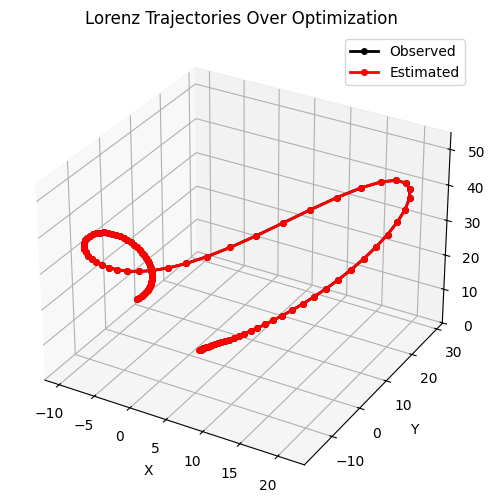

In [120]:
# Visualize the trajectories
fig = plt.figure(figsize=(14, 6))

# 3D plot of all trajectories
ax1 = fig.add_subplot(121, projection='3d')

# Plot the true (observed) trajectory
true_traj_np = true_traj.detach().numpy()
ax1.plot(true_traj_np[:, 0], true_traj_np[:, 1], true_traj_np[:, 2], 
         'o-', linewidth=2, markersize=4, label='Observed', color='black')
final_online_traj_np = final_online_traj.detach().numpy()
ax1.plot(final_online_traj_np[:, 0], final_online_traj_np[:, 1], final_online_traj_np[:, 2], 
         'o-', linewidth=2, markersize=4, label='Estimated', color='red')


ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Lorenz Trajectories Over Optimization')
ax1.legend()


In [111]:
def get_observations(state0):
    # Fake "observed" data (normally you'd load real data)
    with torch.no_grad():
        true_time, true_traj = run_lorenz(
            state0,
            t0=0,
            steps=100,
            dt=0.01,
            sigma=torch.tensor(10.0),
            rho=torch.tensor(28.0),
            beta=torch.tensor(8/3),
        )
        return true_time, true_traj

In [ ]:
def online_optimization(state0, num_tot_steps=200000):
    # Reset parameters for online estimation
    sigma_online = torch.tensor(8.0, requires_grad=True)
    rho_online   = torch.tensor(20.0, requires_grad=True)
    beta_online  = torch.tensor(3.0, requires_grad=True)

    true_time, true_traj = get_observations(state0)

    # Starting state
    current_state = state0.clone()
    current_time = 0.0

    # Extract times and states from true trajectory
    true_times = true_time
    true_states = true_traj

    # Store results for visualization
    online_trajectories = []
    online_losses = []
    online_params = []

    # Number of optimization trials per observation
    # In the previous optimization we ran 2000 trials, each 100 time steps
    # Let's keep the total number of simulated steps the same such that per 
    # time step we optimize with n_trials_online trials
    n_trials_online = int(num_tot_steps / 100)

    # Process each observation
    for obs_idx in range(len(true_states)):
        target_time = true_times[obs_idx].item()
        dt_to_target = target_time - current_time
        num_steps_to_target = 1 #int(dt_to_target / 0.01)  # Currently one step from previous observation to next
        observed_state = true_states[obs_idx]
        target_time = num_steps_to_target * 0.01 + current_time
        # Optimizer for this online step
        optimizer_online = torch.optim.Adam([sigma_online, rho_online, beta_online], lr=1e-2)
        
        best_loss = float('inf')
        best_pred_state = None
        
        # Run N optimization trials for this observation
        for trial in range(n_trials_online):
            optimizer_online.zero_grad()
            
            # Advance from current state to next observation point
            next_state = run_lorenz(current_state, current_time, num_steps_to_target, 0.01, sigma_online, rho_online, beta_online)[1][-1]
            
            # Compute loss against observed state
            loss = torch.mean((next_state - observed_state) ** 2)
            
            loss.backward()
            optimizer_online.step()
            
            # Track best solution
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_pred_state = next_state.detach().clone()
        
        # Update current state and time with optimal prediction
        current_state = best_pred_state.detach().requires_grad_(True)
        current_time = target_time
        
        # Store results
        online_trajectories.append((obs_idx, current_state.detach().clone()))
        online_losses.append((obs_idx, best_loss))
        online_params.append({
            'obs_idx': obs_idx,
            'sigma': sigma_online.item(),
            'rho': rho_online.item(),
            'beta': beta_online.item(),
            'loss': best_loss
        })
        
        if obs_idx % 1 == 0 or obs_idx == len(true_traj) - 1:
            print(f"Obs {obs_idx:3d} | Loss={best_loss:.6f} | "
                f"sigma={sigma_online.item():.3f}, rho={rho_online.item():.3f}, beta={beta_online.item():.3f}")

    # Compute final loss from all concatenated online trajectories
    final_online_traj = torch.stack([traj for _, traj in online_trajectories])
    final_loss = torch.mean((final_online_traj - true_states) ** 2).item()
    print(f"Final online estimation loss: {final_loss:.6f}")

    print(f"\nOnline estimation complete. Processed {len(true_traj)-1} observations.")
    return final_online_traj, final_loss

def scenario_optimization(state0, num_tot_steps=200000):
    # Set number of trials 
    num_trials = int(num_tot_steps / 100)


    # Initial parameter choices
    sigma = torch.tensor(8.0, requires_grad=True)
    rho   = torch.tensor(20.0, requires_grad=True)
    beta  = torch.tensor(3.0, requires_grad=True)

    true_time, true_traj = get_observations(state0)

    optimizer = torch.optim.Adam([sigma, rho, beta], lr=1e-2)

    # Store trajectories and losses for visualization
    stored_trajectories = []
    stored_losses = []

    for trial in range(num_trials):
        optimizer.zero_grad()

        pred_time, pred_traj = run_lorenz(state0, t0=0, steps=100, dt=0.01, sigma=sigma, rho=rho, beta=beta)
        loss = torch.mean((pred_traj - true_traj) ** 2)

        loss.backward()   # <-- AUTOGRAD HERE
        optimizer.step()

        if trial % 20 == 0 or trial == num_trials - 1:
            print(f"Trial {trial:4d} | Loss={loss.item():.6f} "
                f"sigma={sigma.item():.3f}, rho={rho.item():.3f}, beta={beta.item():.3f}")
            # Store trajectory and loss for plotting
            stored_trajectories.append((trial, pred_traj.detach().clone()))
            stored_losses.append((trial, loss.item()))
    return [traj for _, traj in stored_trajectories], [loss for _, loss in stored_losses]



Now let's compare the two methods, the scenario optimization and the online-optimization. We can use the same number of total time steps used during the optimization and compute the resulting loss from both methods. Let's run this and then plot the loss as a function of the total number of time steps.

Trial    0 | Loss=118.959099 sigma=8.010, rho=20.010, beta=2.990
Trial   19 | Loss=108.288452 sigma=8.200, rho=20.200, beta=2.800
Obs   0 | Loss=0.002034 | sigma=8.000, rho=20.200, beta=2.810
Obs   1 | Loss=0.007887 | sigma=8.199, rho=20.400, beta=2.619
Obs   2 | Loss=0.017964 | sigma=8.399, rho=20.599, beta=2.430
Obs   3 | Loss=0.033449 | sigma=8.599, rho=20.799, beta=2.251
Obs   4 | Loss=0.056173 | sigma=8.799, rho=20.999, beta=2.123
Obs   5 | Loss=0.088623 | sigma=8.999, rho=21.199, beta=1.966
Obs   6 | Loss=0.134032 | sigma=9.199, rho=21.399, beta=1.780
Obs   7 | Loss=0.196535 | sigma=9.398, rho=21.599, beta=1.585
Obs   8 | Loss=0.281362 | sigma=9.598, rho=21.799, beta=1.387
Obs   9 | Loss=0.395080 | sigma=9.798, rho=21.999, beta=1.188
Obs  10 | Loss=0.545886 | sigma=9.998, rho=22.199, beta=0.989
Obs  11 | Loss=0.743938 | sigma=10.198, rho=22.399, beta=0.790
Obs  12 | Loss=1.001743 | sigma=10.398, rho=22.599, beta=0.590
Obs  13 | Loss=1.334578 | sigma=10.598, rho=22.799, beta=0.390

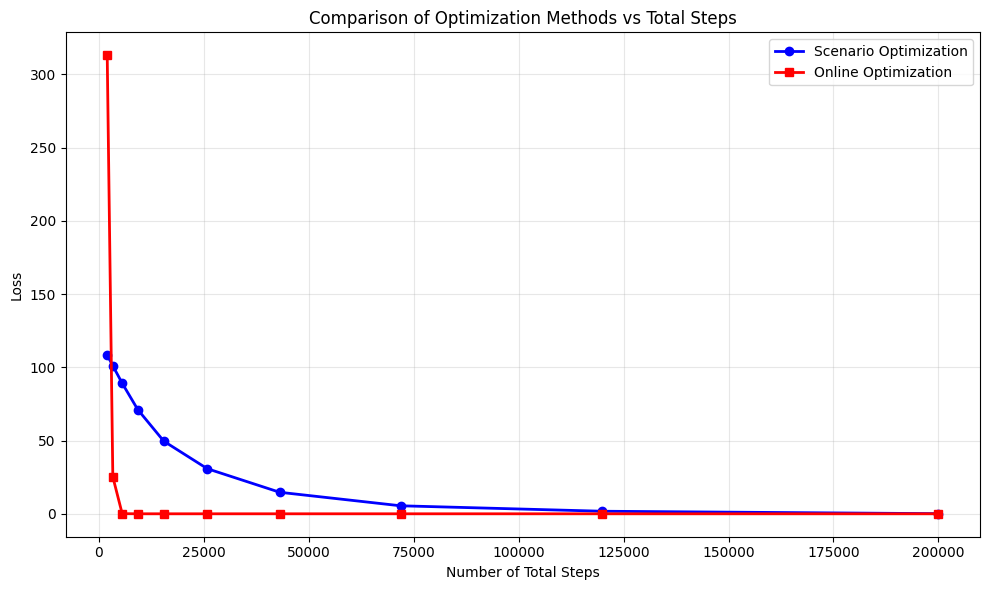

In [121]:
# Initial condition
state0 = torch.tensor([1.0, 1.0, 1.0])
output = []
for num_tot_steps in [int(x) for x in np.logspace(np.log10(2000), np.log10(200000), 10)]:
    output.append((num_tot_steps, scenario_optimization(state0, num_tot_steps=num_tot_steps), online_optimization(state0, num_tot_steps=num_tot_steps)))
# Extract data for plotting
steps = [item[0] for item in output]
scenario_losses = [item[1] for item in output]
online_losses = [item[2] for item in output]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, scenario_losses, 'b-o', label='Scenario Optimization', linewidth=2, markersize=6)
plt.plot(steps, online_losses, 'r-s', label='Online Optimization', linewidth=2, markersize=6)
plt.xlabel('Number of Total Steps')
plt.ylabel('Loss')
plt.title('Comparison of Optimization Methods vs Total Steps')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


We can see that the online-optimization, which optimizes each timestep, performs better as soon as the number of steps is reasonably large. For very large numbers the two approaches become idential. The way I interpret this is that the online optimization per timestep optimizes smaller problems with less complicated loss functions. Therefore, the overall number of steps needed to optimize the full trajectory ends up being smaller than for the scenario-opitmization approach that optimizes the full trajectory.

The real-time online optimization of course only makes sense if the optimization between observations can get carried out faster than real-time. That is, as a new observation comes in, we need to advance the state from the time the last observation was obtained, but not once, but N-trial times.